In [1]:
from datetime import datetime
from tqdm import tqdm
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from typing import List
from pathlib import Path
from train.main.models import get_default_combined_sampler
import torch
from IPython.display import Audio
import warnings
from sklearn.metrics import average_precision_score

In [2]:
def get_mean_ap(df):
    all_samples = set(df.file)
    get_sample_idx = {sample: i for i, sample in enumerate(all_samples)}
    
    all_classes = set(df.sci_name)
    get_class_idx = {c: i for i, c in enumerate(all_classes)}
    
    
    y_true = np.zeros((len(all_samples), len(all_classes))).astype("int32")
    y_score = np.zeros((len(all_samples), len(all_classes)))
    
    for _, x in df.iterrows():
        sample_idx = get_sample_idx[x.file]
        true_class_idx = get_class_idx[x.sci_name]
        
        y_true[sample_idx, true_class_idx] = 1

        # detections of classes that are not in set of classes are irrelevant for mAP
        if x.detected_sci_name not in all_classes:
            continue
        
        pred_class_idx = get_class_idx[x.detected_sci_name]
        
        # there may be multiple detections for one class within one sample: use max confidence
        if y_score[sample_idx, pred_class_idx] < x.confidence:
            y_score[sample_idx, pred_class_idx] = x.confidence
    

    score = average_precision_score(y_true=y_true, y_score=y_score, average="macro")
    return score

In [15]:
exp_dir = "/data/tests/analysed"

step_exp = [
    "steps25_scale5_v3.csv",
    "steps50_scale5_v3.csv",
    "steps100_scale5_v3.csv",
    "steps200_scale5_v3.csv",
    "steps400_scale5_v3.csv",
    "steps800_scale5_v3.csv",
]
scale_exp = [
    "steps100_scale1_v3.csv",
    "steps100_scale2,5_v3.csv",
    "steps100_scale5_v3.csv",
    "steps100_scale7,5_v3.csv",
    "steps100_scale10_v3.csv",
    "steps100_scale15_v3.csv",
]
model_exp = [
    "steps100_scale1_v2.csv", # v2 is without cfg -> only scale 1 sensible
    "steps100_scale5_v3.csv",
    "steps100_scale5_v3_strat.csv",
    "steps100_scale10_v3.csv",
    "steps100_scale10_v3_strat.csv",
]

for exp in scale_exp:
    print(exp[:-4])
    df = pd.read_csv(os.path.join(exp_dir, exp))

    # uses max detection conf for file and dtetected class
    mean_ap = get_mean_ap(df) 
    
    y_true = df.sci_name == df.detected_sci_name
    y_score = df.confidence

    print(f"mAP: {mean_ap}")
    # print("# detections @0.1: ", len(df))
    # print(f"mean conf among correct @0.1: {y_score[y_true].mean()}")
    print()


steps100_scale1_v3
mAP: 0.06647889912992104

steps100_scale2,5_v3
mAP: 0.18017816193926264

steps100_scale5_v3
mAP: 0.21222142035140634

steps100_scale7,5_v3
mAP: 0.17517405998219318

steps100_scale10_v3
mAP: 0.13687974636240047

steps100_scale15_v3
mAP: 0.07997132459170761



In [3]:
exp_dir = "/data/tests/analysed"
steps = [25, 50, 100, 200, 400, 800]
mean_ap_steps = []
for step in tqdm(steps):
    df = pd.read_csv(os.path.join(exp_dir, f"steps{step}_scale5_v3.csv"))
    mean_ap = get_mean_ap(df) 
    mean_ap_steps.append(mean_ap)
    
scales = [1, 2.5, 5, 7.5, 10, 15]
mean_ap_scale = []
for scale in tqdm(scales):
    scale_str = str(scale).replace(".", ",")
    df = pd.read_csv(os.path.join(exp_dir, f"steps100_scale{scale_str}_v3.csv"))
    mean_ap = get_mean_ap(df) 
    mean_ap_scale.append(mean_ap)

100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


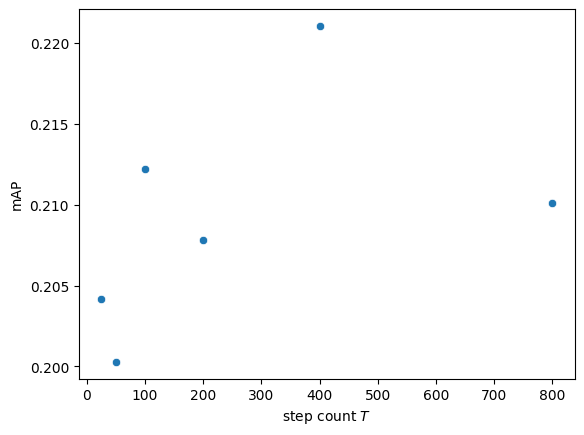

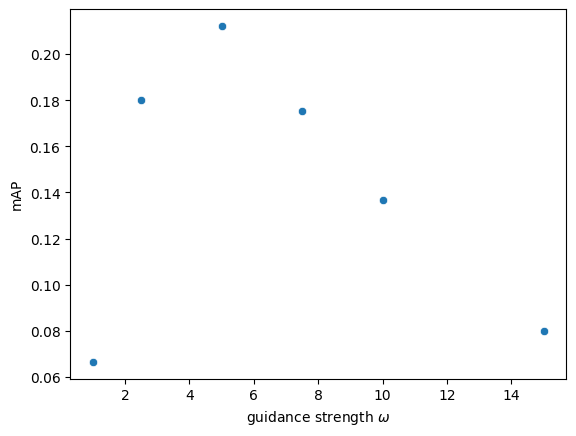

In [24]:
ax = sns.scatterplot(x=steps, y=mean_ap_steps)
plt.ylabel("mAP")
plt.xlabel("step count $T$")
plt.savefig("/data/plots/step_test.svg")
plt.show()

sns.scatterplot(x=scales, y=mean_ap_scale)
plt.ylabel("mAP")
plt.xlabel("guidance strength $\omega$")
plt.savefig("/data/plots/scale_test.svg")
plt.show()

In [ ]:
data_dir = "/data/tests/generated"
step_exp = [
    "steps25_scale5_v3",
    "steps50_scale5_v3",
    "steps100_scale5_v3",
    "steps200_scale5_v3",
    "steps400_scale5_v3",
    "steps800_scale5_v3",
]
scale_exp = [
    "steps100_scale1_v3",
    "steps100_scale2,5_v3",
    "steps100_scale5_v3",
    "steps100_scale10_v3",
    "steps100_scale15_v3",
]
model_exp = [
    "steps100_scale1_v2",
    "steps100_scale10_v2",
    "steps100_scale10_v3",
    "steps100_scale10_v3_strat",
]

audios = os.listdir(os.path.join(data_dir, "steps100_scale10_v3"))
for f in audios[:5]:
    print(f)
    for exp in scale_exp:
        print(exp)
        display(Audio(filename=os.path.join(data_dir, exp, f)))